In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from sklearn.metrics import log_loss
from sklearn.ensemble import VotingClassifier

from sklearn.calibration import CalibratedClassifierCV


Reading Dataset

In [90]:
df=pd.read_csv("Extended_Multi-Omics_Dataset__5000_samples_.csv")
df.head(10)
df.tail(5)

,Unnamed: 0.1,Unnamed: 0,BRCA1_genomic,BRCA1_transcriptomic,BRCA1_proteomic,BRCA2_genomic,BRCA2_transcriptomic,BRCA2_proteomic,TP53_genomic,TP53_transcriptomic,...,SMAD4_proteomic,resistance_label,age,gender,ethnicity,chemotherapy_type,treatment_duration,tumor_grade,tumor_stage,clinical_outcome
4995,289,289,-1.232540,-0.684492,0.457324,2.098221,-0.138082,0.591136,-0.106971,1.942246,...,-2.331638,resistant,48,Female,Asian,Regimen C,4,4,Stage III,Progression
4996,294,294,-2.403669,1.392456,0.672293,-1.500477,-1.478777,1.672266,NaN,-0.834185,...,-1.157195,resistant,53,Male,Hispanic,Regimen C,3,4,Stage III,Progression
4997,450,450,0.765402,1.073413,0.498690,-1.942498,-0.155422,-1.155708,-0.202606,0.980004,...,-0.255624,NaN,69,Female,Black,Regimen C,10,3,Stage I,Progression
4998,903,903,0.139351,-0.633330,-0.616855,0.846722,0.984656,0.783823,0.792962,0.569030,...,2.151323,sensitive,71,Male,Hispanic,Regimen A,5,1,Stage III,Stable
4999,214,214,2.093198,-1.511883,1.159381,0.973102,-0.779093,0.203236,-0.457633,0.185689,...,-0.233309,sensitive,46,Male,Hispanic,Regimen C,6,2,Stage I,Stable


In [92]:
#droping unnesseray columns 
df=df.drop('Unnamed: 0',axis=1)
df=df.drop('tumor_grade',axis=1)
df=df.drop('Unnamed: 0.1',axis=1)
# temp for just checking missing valuse in clinical data
temp=df[['resistance_label', 'age',
       'gender', 'ethnicity', 'chemotherapy_type', 'treatment_duration',
       'tumor_stage', 'clinical_outcome']]
#all numirical genomic data
x=df.iloc[:,:60]
original_columns=x.columns

In [94]:
x

,BRCA1_genomic,BRCA1_transcriptomic,BRCA1_proteomic,BRCA2_genomic,BRCA2_transcriptomic,BRCA2_proteomic,TP53_genomic,TP53_transcriptomic,TP53_proteomic,ATM_genomic,...,CDH1_proteomic,ARID1A_genomic,ARID1A_transcriptomic,ARID1A_proteomic,KRAS_genomic,KRAS_transcriptomic,KRAS_proteomic,SMAD4_genomic,SMAD4_transcriptomic,SMAD4_proteomic
0,-0.694713,-0.409282,-0.524088,0.152355,NaN,1.121031,0.000207,-0.009300,-0.327895,0.155191,...,-0.010190,-1.208506,0.299469,1.002222,0.593181,0.059304,0.565291,-0.223245,1.044175,1.347181
1,1.592025,-0.587738,-1.443201,0.638187,1.744311,0.663598,0.204798,0.409141,1.414841,-0.874199,...,-1.538794,-0.057381,NaN,1.056715,-0.979691,0.415395,-0.175845,0.812034,-0.615397,NaN
2,0.269784,0.011594,-1.025943,NaN,-1.334827,-0.124077,1.636105,0.822859,-0.923119,-0.072429,...,-0.292375,-0.047902,1.698181,-0.379144,0.561112,0.349701,0.062074,-0.958112,0.523665,-1.925637
3,-1.187765,-0.397323,0.534365,0.091094,-0.851540,0.006273,-1.531535,1.150267,-0.205284,1.118550,...,0.661383,-2.662336,0.540007,0.313300,0.497026,-1.928427,0.292830,-0.542501,1.602190,0.361721
4,2.412615,0.784604,-0.019260,-0.262891,0.022466,NaN,-1.180813,1.114322,0.715381,0.718186,...,NaN,2.155470,-0.495627,1.296774,-0.885340,-1.536663,0.987496,-0.218814,1.271249,1.470893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.232540,-0.684492,0.457324,2.098221,-0.138082,0.591136,-0.106971,1.942246,NaN,0.094621,...,2.202952,-0.957253,0.539574,0.288545,0.528159,-0.284904,-0.592256,0.226493,-0.456029,-2.331638
4996,-2.403669,1.392456,0.672293,-1.500477,-1.478777,1.672266,NaN,-0.834185,-2.266052,-0.350778,...,0.956554,-0.070926,-0.941599,0.517374,0.001503,1.050505,0.133337,-1.437188,-0.496744,-1.157195
4997,0.765402,1.073413,0.498690,-1.942498,-0.155422,-1.155708,-0.202606,0.980004,0.305151,1.148091,...,-1.633039,1.064273,1.706536,1.283887,NaN,1.539460,0.357451,-1.319617,-0.521895,-0.255624
4998,0.139351,-0.633330,-0.616855,0.846722,0.984656,0.783823,0.792962,0.569030,0.131523,-0.175380,...,-0.416154,0.070638,-0.049535,-1.450612,-0.529286,-0.258399,1.859715,-0.160022,0.273241,2.151323


In [96]:
temp.isna().sum()

resistance_label      174
age                     0
gender                  0
ethnicity               0
chemotherapy_type       0
treatment_duration      0
tumor_stage             0
clinical_outcome        0
dtype: int64

In [98]:
df.columns


Index(['BRCA1_genomic', 'BRCA1_transcriptomic', 'BRCA1_proteomic',
       'BRCA2_genomic', 'BRCA2_transcriptomic', 'BRCA2_proteomic',
       'TP53_genomic', 'TP53_transcriptomic', 'TP53_proteomic', 'ATM_genomic',
       'ATM_transcriptomic', 'ATM_proteomic', 'CHEK2_genomic',
       'CHEK2_transcriptomic', 'CHEK2_proteomic', 'PALB2_genomic',
       'PALB2_transcriptomic', 'PALB2_proteomic', 'BARD1_genomic',
       'BARD1_transcriptomic', 'BARD1_proteomic', 'MRE11A_genomic',
       'MRE11A_transcriptomic', 'MRE11A_proteomic', 'RAD51_genomic',
       'RAD51_transcriptomic', 'RAD51_proteomic', 'ERBB2_genomic',
       'ERBB2_transcriptomic', 'ERBB2_proteomic', 'PIK3CA_genomic',
       'PIK3CA_transcriptomic', 'PIK3CA_proteomic', 'AKT1_genomic',
       'AKT1_transcriptomic', 'AKT1_proteomic', 'PTEN_genomic',
       'PTEN_transcriptomic', 'PTEN_proteomic', 'MAPK1_genomic',
       'MAPK1_transcriptomic', 'MAPK1_proteomic', 'ESR1_genomic',
       'ESR1_transcriptomic', 'ESR1_proteomic', 'FGFR1_

In [100]:
df["resistance_label"]

0       sensitive
1       sensitive
2       resistant
3       resistant
4       sensitive
          ...    
4995    resistant
4996    resistant
4997          NaN
4998    sensitive
4999    sensitive
Name: resistance_label, Length: 5000, dtype: object

In [102]:
df

,BRCA1_genomic,BRCA1_transcriptomic,BRCA1_proteomic,BRCA2_genomic,BRCA2_transcriptomic,BRCA2_proteomic,TP53_genomic,TP53_transcriptomic,TP53_proteomic,ATM_genomic,...,SMAD4_transcriptomic,SMAD4_proteomic,resistance_label,age,gender,ethnicity,chemotherapy_type,treatment_duration,tumor_stage,clinical_outcome
0,-0.694713,-0.409282,-0.524088,0.152355,NaN,1.121031,0.000207,-0.009300,-0.327895,0.155191,...,1.044175,1.347181,sensitive,30,Male,Caucasian,Regimen A,7,Stage IV,Stable
1,1.592025,-0.587738,-1.443201,0.638187,1.744311,0.663598,0.204798,0.409141,1.414841,-0.874199,...,-0.615397,NaN,sensitive,72,Female,Asian,Regimen C,10,Stage III,Progression
2,0.269784,0.011594,-1.025943,NaN,-1.334827,-0.124077,1.636105,0.822859,-0.923119,-0.072429,...,0.523665,-1.925637,resistant,71,Male,Asian,Regimen A,11,Stage I,Stable
3,-1.187765,-0.397323,0.534365,0.091094,-0.851540,0.006273,-1.531535,1.150267,-0.205284,1.118550,...,1.602190,0.361721,resistant,60,Female,Black,Regimen B,3,Stage II,Remission
4,2.412615,0.784604,-0.019260,-0.262891,0.022466,NaN,-1.180813,1.114322,0.715381,0.718186,...,1.271249,1.470893,sensitive,40,Male,Black,Regimen C,4,Stage I,Stable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.232540,-0.684492,0.457324,2.098221,-0.138082,0.591136,-0.106971,1.942246,NaN,0.094621,...,-0.456029,-2.331638,resistant,48,Female,Asian,Regimen C,4,Stage III,Progression
4996,-2.403669,1.392456,0.672293,-1.500477,-1.478777,1.672266,NaN,-0.834185,-2.266052,-0.350778,...,-0.496744,-1.157195,resistant,53,Male,Hispanic,Regimen C,3,Stage III,Progression
4997,0.765402,1.073413,0.498690,-1.942498,-0.155422,-1.155708,-0.202606,0.980004,0.305151,1.148091,...,-0.521895,-0.255624,NaN,69,Female,Black,Regimen C,10,Stage I,Progression
4998,0.139351,-0.633330,-0.616855,0.846722,0.984656,0.783823,0.792962,0.569030,0.131523,-0.175380,...,0.273241,2.151323,sensitive,71,Male,Hispanic,Regimen A,5,Stage III,Stable


In [104]:
X=df.drop("resistance_label",axis=1)
y=df["resistance_label"]


In [106]:
X.isna().sum()

BRCA1_genomic           169
BRCA1_transcriptomic    163
BRCA1_proteomic         163
BRCA2_genomic           149
BRCA2_transcriptomic    102
                       ... 
ethnicity                 0
chemotherapy_type         0
treatment_duration        0
tumor_stage               0
clinical_outcome          0
Length: 67, dtype: int64

In [108]:
imputer = IterativeImputer(random_state=42)
X_imputed = imputer.fit_transform(x)
X_imputed = pd.DataFrame(X_imputed, columns=original_columns)
X_imputed


,BRCA1_genomic,BRCA1_transcriptomic,BRCA1_proteomic,BRCA2_genomic,BRCA2_transcriptomic,BRCA2_proteomic,TP53_genomic,TP53_transcriptomic,TP53_proteomic,ATM_genomic,...,CDH1_proteomic,ARID1A_genomic,ARID1A_transcriptomic,ARID1A_proteomic,KRAS_genomic,KRAS_transcriptomic,KRAS_proteomic,SMAD4_genomic,SMAD4_transcriptomic,SMAD4_proteomic
0,-0.694713,-0.409282,-0.524088,0.152355,0.242705,1.121031,0.000207,-0.009300,-0.327895,0.155191,...,-0.010190,-1.208506,0.299469,1.002222,0.593181,0.059304,0.565291,-0.223245,1.044175,1.347181
1,1.592025,-0.587738,-1.443201,0.638187,1.744311,0.663598,0.204798,0.409141,1.414841,-0.874199,...,-1.538794,-0.057381,0.216725,1.056715,-0.979691,0.415395,-0.175845,0.812034,-0.615397,0.401048
2,0.269784,0.011594,-1.025943,0.034849,-1.334827,-0.124077,1.636105,0.822859,-0.923119,-0.072429,...,-0.292375,-0.047902,1.698181,-0.379144,0.561112,0.349701,0.062074,-0.958112,0.523665,-1.925637
3,-1.187765,-0.397323,0.534365,0.091094,-0.851540,0.006273,-1.531535,1.150267,-0.205284,1.118550,...,0.661383,-2.662336,0.540007,0.313300,0.497026,-1.928427,0.292830,-0.542501,1.602190,0.361721
4,2.412615,0.784604,-0.019260,-0.262891,0.022466,-0.008800,-1.180813,1.114322,0.715381,0.718186,...,-0.032811,2.155470,-0.495627,1.296774,-0.885340,-1.536663,0.987496,-0.218814,1.271249,1.470893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.232540,-0.684492,0.457324,2.098221,-0.138082,0.591136,-0.106971,1.942246,-0.203036,0.094621,...,2.202952,-0.957253,0.539574,0.288545,0.528159,-0.284904,-0.592256,0.226493,-0.456029,-2.331638
4996,-2.403669,1.392456,0.672293,-1.500477,-1.478777,1.672266,0.583625,-0.834185,-2.266052,-0.350778,...,0.956554,-0.070926,-0.941599,0.517374,0.001503,1.050505,0.133337,-1.437188,-0.496744,-1.157195
4997,0.765402,1.073413,0.498690,-1.942498,-0.155422,-1.155708,-0.202606,0.980004,0.305151,1.148091,...,-1.633039,1.064273,1.706536,1.283887,0.271824,1.539460,0.357451,-1.319617,-0.521895,-0.255624
4998,0.139351,-0.633330,-0.616855,0.846722,0.984656,0.783823,0.792962,0.569030,0.131523,-0.175380,...,-0.416154,0.070638,-0.049535,-1.450612,-0.529286,-0.258399,1.859715,-0.160022,0.273241,2.151323


In [109]:
y.isna().sum()

174

In [110]:
category_mapping = {'sensitive': 0, 'resistant': 1}
df['resistance_label_encoded'] = df['resistance_label'].map(category_mapping)
y=df['resistance_label_encoded']

In [112]:
imputer = SimpleImputer(strategy='most_frequent')

# Apply the imputer to the target (y)
y_imputed = imputer.fit_transform(y.values.reshape(-1, 1)).ravel() 
pd.DataFrame(y_imputed)


,0
0,0.0
1,0.0
2,1.0
3,1.0
4,0.0
...,...
4995,1.0
4996,1.0
4997,0.0
4998,0.0


In [113]:
# Import required libraries
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Assuming 'df' is your dataset
label_encoder = LabelEncoder()

# Encoding the 'gender' column
df['gender'] = label_encoder.fit_transform(df['gender'])
df_encoded = pd.get_dummies(df, columns=['ethnicity', 'chemotherapy_type', 'tumor_stage', 'clinical_outcome'], drop_first=False)
df_encoded.columns
X_imputed

,BRCA1_genomic,BRCA1_transcriptomic,BRCA1_proteomic,BRCA2_genomic,BRCA2_transcriptomic,BRCA2_proteomic,TP53_genomic,TP53_transcriptomic,TP53_proteomic,ATM_genomic,...,CDH1_proteomic,ARID1A_genomic,ARID1A_transcriptomic,ARID1A_proteomic,KRAS_genomic,KRAS_transcriptomic,KRAS_proteomic,SMAD4_genomic,SMAD4_transcriptomic,SMAD4_proteomic
0,-0.694713,-0.409282,-0.524088,0.152355,0.242705,1.121031,0.000207,-0.009300,-0.327895,0.155191,...,-0.010190,-1.208506,0.299469,1.002222,0.593181,0.059304,0.565291,-0.223245,1.044175,1.347181
1,1.592025,-0.587738,-1.443201,0.638187,1.744311,0.663598,0.204798,0.409141,1.414841,-0.874199,...,-1.538794,-0.057381,0.216725,1.056715,-0.979691,0.415395,-0.175845,0.812034,-0.615397,0.401048
2,0.269784,0.011594,-1.025943,0.034849,-1.334827,-0.124077,1.636105,0.822859,-0.923119,-0.072429,...,-0.292375,-0.047902,1.698181,-0.379144,0.561112,0.349701,0.062074,-0.958112,0.523665,-1.925637
3,-1.187765,-0.397323,0.534365,0.091094,-0.851540,0.006273,-1.531535,1.150267,-0.205284,1.118550,...,0.661383,-2.662336,0.540007,0.313300,0.497026,-1.928427,0.292830,-0.542501,1.602190,0.361721
4,2.412615,0.784604,-0.019260,-0.262891,0.022466,-0.008800,-1.180813,1.114322,0.715381,0.718186,...,-0.032811,2.155470,-0.495627,1.296774,-0.885340,-1.536663,0.987496,-0.218814,1.271249,1.470893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,-1.232540,-0.684492,0.457324,2.098221,-0.138082,0.591136,-0.106971,1.942246,-0.203036,0.094621,...,2.202952,-0.957253,0.539574,0.288545,0.528159,-0.284904,-0.592256,0.226493,-0.456029,-2.331638
4996,-2.403669,1.392456,0.672293,-1.500477,-1.478777,1.672266,0.583625,-0.834185,-2.266052,-0.350778,...,0.956554,-0.070926,-0.941599,0.517374,0.001503,1.050505,0.133337,-1.437188,-0.496744,-1.157195
4997,0.765402,1.073413,0.498690,-1.942498,-0.155422,-1.155708,-0.202606,0.980004,0.305151,1.148091,...,-1.633039,1.064273,1.706536,1.283887,0.271824,1.539460,0.357451,-1.319617,-0.521895,-0.255624
4998,0.139351,-0.633330,-0.616855,0.846722,0.984656,0.783823,0.792962,0.569030,0.131523,-0.175380,...,-0.416154,0.070638,-0.049535,-1.450612,-0.529286,-0.258399,1.859715,-0.160022,0.273241,2.151323


In [114]:
# One-hot encode other categorical columns
final_df = pd.concat([df_encoded[['age',
       'gender', 'treatment_duration',
       'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'chemotherapy_type_Regimen A',
       'chemotherapy_type_Regimen B', 'chemotherapy_type_Regimen C',
       'tumor_stage_Stage I', 'tumor_stage_Stage II', 'tumor_stage_Stage III',
       'tumor_stage_Stage IV', 'clinical_outcome_Progression',
       'clinical_outcome_Remission', 'clinical_outcome_Stable']], X_imputed], axis=1)
final_df['resistance_label'] = y_imputed
final_df[[
        'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'chemotherapy_type_Regimen A',
       'chemotherapy_type_Regimen B', 'chemotherapy_type_Regimen C',
       'tumor_stage_Stage I', 'tumor_stage_Stage II', 'tumor_stage_Stage III',
       'tumor_stage_Stage IV', 'clinical_outcome_Progression',
       'clinical_outcome_Remission', 'clinical_outcome_Stable']]=final_df[[
        'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Caucasian',
       'ethnicity_Hispanic', 'chemotherapy_type_Regimen A',
       'chemotherapy_type_Regimen B', 'chemotherapy_type_Regimen C',
       'tumor_stage_Stage I', 'tumor_stage_Stage II', 'tumor_stage_Stage III',
       'tumor_stage_Stage IV', 'clinical_outcome_Progression',
       'clinical_outcome_Remission', 'clinical_outcome_Stable']].astype(int)

#final_df = final_df.astype(int)

# Display the encoded dataframe
final_df

,age,gender,treatment_duration,ethnicity_Asian,ethnicity_Black,ethnicity_Caucasian,ethnicity_Hispanic,chemotherapy_type_Regimen A,chemotherapy_type_Regimen B,chemotherapy_type_Regimen C,...,ARID1A_genomic,ARID1A_transcriptomic,ARID1A_proteomic,KRAS_genomic,KRAS_transcriptomic,KRAS_proteomic,SMAD4_genomic,SMAD4_transcriptomic,SMAD4_proteomic,resistance_label
0,30,1,7,0,0,1,0,1,0,0,...,-1.208506,0.299469,1.002222,0.593181,0.059304,0.565291,-0.223245,1.044175,1.347181,0.0
1,72,0,10,1,0,0,0,0,0,1,...,-0.057381,0.216725,1.056715,-0.979691,0.415395,-0.175845,0.812034,-0.615397,0.401048,0.0
2,71,1,11,1,0,0,0,1,0,0,...,-0.047902,1.698181,-0.379144,0.561112,0.349701,0.062074,-0.958112,0.523665,-1.925637,1.0
3,60,0,3,0,1,0,0,0,1,0,...,-2.662336,0.540007,0.313300,0.497026,-1.928427,0.292830,-0.542501,1.602190,0.361721,1.0
4,40,1,4,0,1,0,0,0,0,1,...,2.155470,-0.495627,1.296774,-0.885340,-1.536663,0.987496,-0.218814,1.271249,1.470893,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,48,0,4,1,0,0,0,0,0,1,...,-0.957253,0.539574,0.288545,0.528159,-0.284904,-0.592256,0.226493,-0.456029,-2.331638,1.0
4996,53,1,3,0,0,0,1,0,0,1,...,-0.070926,-0.941599,0.517374,0.001503,1.050505,0.133337,-1.437188,-0.496744,-1.157195,1.0
4997,69,0,10,0,1,0,0,0,0,1,...,1.064273,1.706536,1.283887,0.271824,1.539460,0.357451,-1.319617,-0.521895,-0.255624,0.0
4998,71,1,5,0,0,0,1,1,0,0,...,0.070638,-0.049535,-1.450612,-0.529286,-0.258399,1.859715,-0.160022,0.273241,2.151323,0.0


In [115]:
final_df["resistance_label"].value_counts()

resistance_label
0.0    3685
1.0    1315
Name: count, dtype: int64

In [116]:
final_df.isna().sum()

age                     0
gender                  0
treatment_duration      0
ethnicity_Asian         0
ethnicity_Black         0
                       ..
KRAS_proteomic          0
SMAD4_genomic           0
SMAD4_transcriptomic    0
SMAD4_proteomic         0
resistance_label        0
Length: 78, dtype: int64

In [117]:
X = final_df.drop('resistance_label', axis=1)  # Features
y = final_df['resistance_label']  # Target variable


In [118]:
y.isna().sum()

0

In [119]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_imputed)

testing

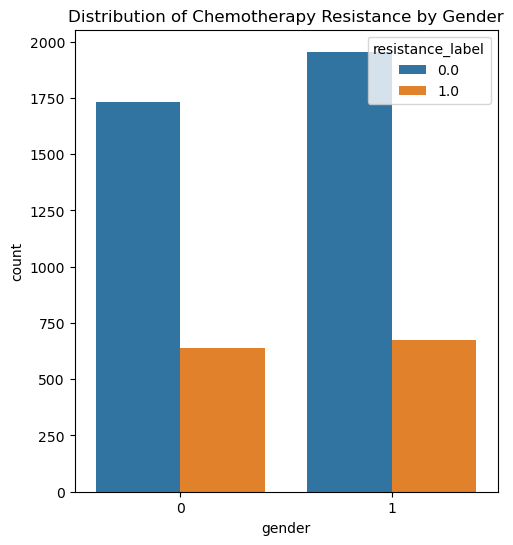

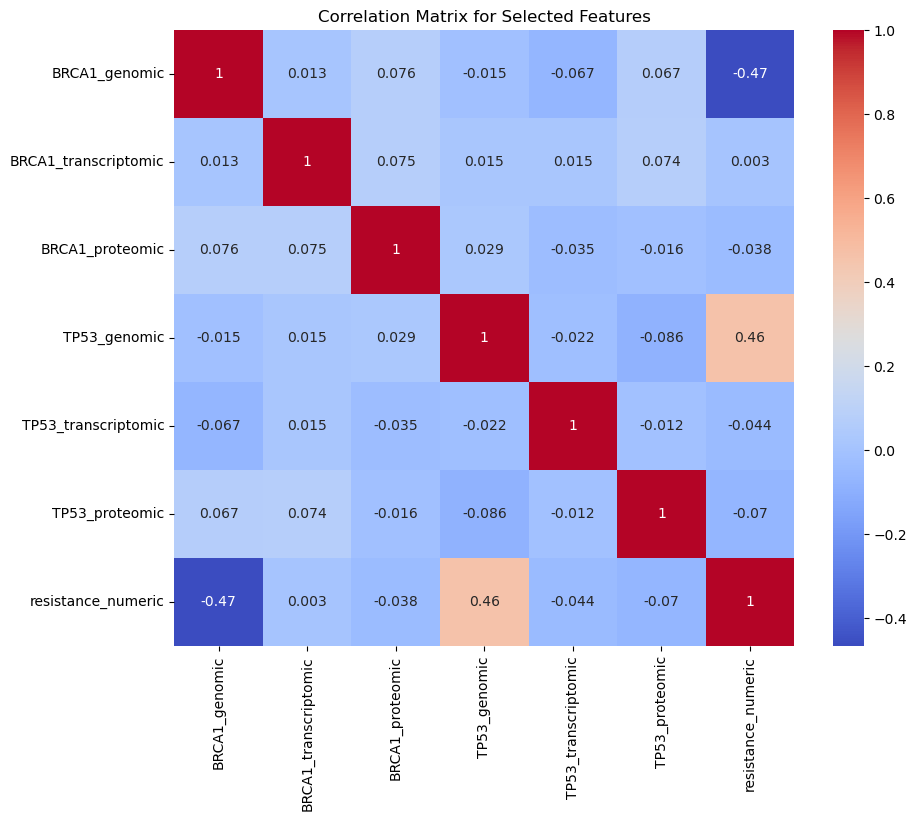

,age,gender,treatment_duration,ethnicity_Asian,ethnicity_Black,ethnicity_Caucasian,ethnicity_Hispanic,chemotherapy_type_Regimen A,chemotherapy_type_Regimen B,chemotherapy_type_Regimen C,...,ARID1A_genomic,ARID1A_transcriptomic,ARID1A_proteomic,KRAS_genomic,KRAS_transcriptomic,KRAS_proteomic,SMAD4_genomic,SMAD4_transcriptomic,SMAD4_proteomic,resistance_label
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,55.145000,0.526200,7.044200,0.262400,0.253200,0.251000,0.233400,0.346800,0.326200,0.327000,...,-0.032003,0.006204,-0.014172,0.031292,0.018994,0.010970,-0.037131,0.053419,0.036943,0.263000
std,14.305569,0.499363,2.600846,0.439983,0.434888,0.433632,0.423037,0.475999,0.468868,0.469164,...,0.972631,0.976437,0.993775,0.999190,0.999599,0.991600,0.973823,0.961457,1.034623,0.440306
min,30.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.265189,-3.265301,-3.631539,-3.317318,-3.151306,-3.288157,-2.844653,-3.070326,-4.157734,0.000000
25%,43.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.708786,-0.599591,-0.684999,-0.651678,-0.626197,-0.599795,-0.695382,-0.573643,-0.614225,0.000000
50%,55.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.065224,-0.007032,-0.025973,0.031197,0.035563,0.033373,-0.050316,0.055227,0.090633,0.000000
75%,67.000000,1.000000,9.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,0.653536,0.654503,0.630020,0.648612,0.655836,0.674346,0.572298,0.693141,0.748374,1.000000
max,79.000000,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.927645,3.231067,3.745379,3.380614,2.813484,3.401876,2.984234,2.864391,3.222928,1.000000


In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Fill missing values with median for visualization purposes

# Summary statistics of numerical features
summary_stats = final_df.describe()

# Visualization: Distribution of chemotherapy resistance across gender
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='gender', hue='resistance_label', data=final_df)
plt.title('Distribution of Chemotherapy Resistance by Gender')

# Visualization: Distribution of chemotherapy resistance across tumor grade
#plt.subplot(1, 2, 2)
#sns.countplot(x='tumor_stage', hue='resistance_label', data=final_df)
#plt.title('Distribution of Chemotherapy Resistance by Tumor Grade')
#plt.tight_layout()

# Correlation matrix of a subset of omics features with resistance label (numeric conversion needed)
data_numeric = final_df.copy()
data_numeric['resistance_numeric'] = final_df['resistance_label']
correlation_features = ['BRCA1_genomic', 'BRCA1_transcriptomic', 'BRCA1_proteomic', 
                        'TP53_genomic', 'TP53_transcriptomic', 'TP53_proteomic', 'resistance_numeric']
correlation_matrix = data_numeric[correlation_features].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Selected Features')
plt.show()

summary_stats


In [ ]:
correlation = final_df.corr()['resistance_label'].drop('resistance_label')
correlation

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

In [ ]:
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


testing using svm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.svm import LinearSVC
model = LinearSVC(C=1, random_state=42)
model.fit(X_train, y_train)
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, train_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

# Print accuracies
print(f"Train Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
# Step 4: Train a Support Vector Machine (SVM) model
#model = SVC(kernel='linear', C=1)  # Linear kernel and regularization strength C=1
#model.fit(X_train, y_train)


In [124]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Display the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.9043419267299865
Confusion Matrix:
[[648  76]
 [ 65 685]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       724
         1.0       0.90      0.91      0.91       750

    accuracy                           0.90      1474
   macro avg       0.90      0.90      0.90      1474
weighted avg       0.90      0.90      0.90      1474



In [126]:
cv_scores = cross_val_score(model, X_scaled, y_imputed, cv=5)  # 5-fold cross-validation

print(f"Cross-validation Scores: {cv_scores}")
print(f"Average Cross-validation Score: {cv_scores.mean():.4f}")

Cross-validation Scores: [0.737 0.737 0.737 0.737 0.737]
Average Cross-validation Score: 0.7370


In [127]:
X = final_df.drop(columns=['resistance_label'])
y = final_df['resistance_label']

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training, validation, and testing sets


In [128]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

# Adjust MLP structure with increased dropout and regularization
model = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', 
                      max_iter=500, random_state=42, alpha=0.5, early_stopping=True,
                      validation_fraction=0.2)

# Train the model
model.fit(X_train, y_train)

# Evaluate performance


MLPClassifier(alpha=0.5, early_stopping=True, hidden_layer_sizes=(16, 8),
              max_iter=500, random_state=42, validation_fraction=0.2)

In [129]:
train_accuracy = model.score(X_train, y_train)
val_accuracy = model.score(X_val, y_val)
test_accuracy = model.score(X_test, y_test)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Make predictions on the test set
y_pred = model.predict(X_test)

# Classification report
print(classification_report(y_test, y_pred))

Training Accuracy: 99.87%
Validation Accuracy: 98.81%
Test Accuracy: 98.51%
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99       737
         1.0       0.98      0.99      0.99       737

    accuracy                           0.99      1474
   macro avg       0.99      0.99      0.99      1474
weighted avg       0.99      0.99      0.99      1474



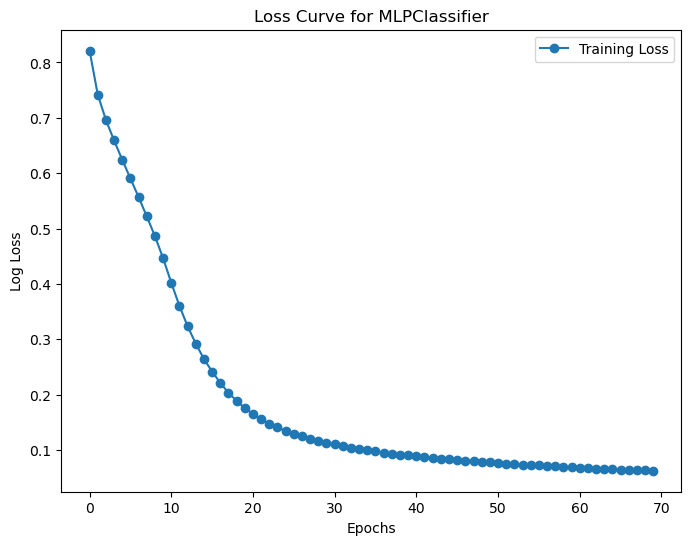

In [131]:
loss_curve = model.loss_curve_

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(loss_curve, label='Training Loss', marker='o')
plt.title('Loss Curve for MLPClassifier')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

In [133]:



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize individual classifiers
log_reg = LogisticRegression(random_state=42)
svm  = LinearSVC(C=1, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam', 
                      max_iter=500, random_state=42, alpha=0.5, early_stopping=True,
                      validation_fraction=0.2)

# Create an ensemble using VotingClassifier
ensemble = VotingClassifier(
    estimators=[
        ('LogReg', log_reg),
        ('SVM', svm),
        ('MLP', mlp)
    ],
    voting='hard'  # Use 'hard' for majority vote or 'soft' for averaged probabilities
)

# Train the ensemble
ensemble.fit(X_train, y_train)

# Predict and evaluate
y_pred = ensemble.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.2f}")


Ensemble Accuracy: 0.90
